In [73]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
from hessians_calc import *
from demo_parity_calc import *
import copy


In [74]:
cols = ['status', 'duration', 'credit_hist', 'purpose', 'credit_amt', 'savings', 'employment', 'installment_rate', 'personal_status', 'debtors', 'residencesince', 'property', 'age', 'install_plans', 'housing', 'existing_credits', 'job', 'maintenance_paying_people', 'telephone', 'foreign_worker', 'result']
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data'
df = pd.read_csv(url, delimiter=' ', names=cols, index_col=False)
df['result'] = df['result'].replace(2,0)

In [75]:
df.head()

,status,duration,credit_hist,purpose,credit_amt,savings,employment,installment_rate,personal_status,debtors,...,property,age,install_plans,housing,existing_credits,job,maintenance_paying_people,telephone,foreign_worker,result
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,0
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,0


In [76]:
def preprocess_german(df):
    df['status'] = df['status'].map({'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}).astype(int)
    df['credit_hist'] = df['credit_hist'].map({'A34': 0, 'A33': 1, 'A32': 2, 'A31': 3, 'A30': 4}).astype(int)
    df.loc[(df['credit_amt'] <= 2000), 'credit_amt'] = 0
    df.loc[(df['credit_amt'] > 2000) & (df['credit_amt'] <= 5000), 'credit_amt'] = 1
    df.loc[(df['credit_amt'] > 5000), 'credit_amt'] = 2
    df.loc[(df['duration'] <= 12), 'duration'] = 0
    df.loc[(df['duration'] > 12) & (df['duration'] <= 24), 'duration'] = 1
    df.loc[(df['duration'] > 24) & (df['duration'] <= 36), 'duration'] = 2
    df.loc[(df['duration'] > 36), 'duration'] = 3
    df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0) # 1 if old, 0 if young
    df['savings'] = df['savings'].map({'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}).astype(int)
    df['employment'] = df['employment'].map({'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}).astype(int)
    df['gender'] = df['personal_status'].map({'A91': 1, 'A92': 0, 'A93': 1, 'A94': 1, 'A95': 0}).astype(int)
    df['debtors'] = df['debtors'].map({'A101': 0, 'A102': 1, 'A103': 2}).astype(int)
    df['property'] = df['property'].map({'A121': 3, 'A122': 2, 'A123': 1, 'A124': 0}).astype(int)
    df['install_plans'] = df['install_plans'].map({'A141': 1, 'A142': 1, 'A143': 0}).astype(int)
    df['job'] = df['job'].map({'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}).astype(int)
    df['telephone'] = df['telephone'].map({'A191': 0, 'A192': 1}).astype(int)
    df['foreign_worker'] = df['foreign_worker'].map({'A201': 1, 'A202': 0}).astype(int)
    pd.get_dummies(df, columns=['purpose', 'housing'], drop_first=True)

    return df

In [77]:
df = preprocess_german(df)

In [78]:
df = df.drop(["purpose", "housing", "personal_status"], axis=1)
x = df[['status', 'duration', 'credit_hist', 'credit_amt', 'savings',
       'employment', 'installment_rate', 'debtors', 'residencesince',
       'property', 'age', 'install_plans', 'existing_credits', 'job',
       'maintenance_paying_people', 'telephone', 'foreign_worker',
       'gender']]

y = df['result']

In [79]:
df.head()

,status,duration,credit_hist,credit_amt,savings,employment,installment_rate,debtors,residencesince,property,age,install_plans,existing_credits,job,maintenance_paying_people,telephone,foreign_worker,result,gender
0,0,0,0,0,4,4,4,0,4,3,1,0,2,2,1,1,1,1,1
1,1,3,2,2,0,2,2,0,2,3,0,0,1,2,1,0,1,0,0
2,3,0,0,1,0,3,2,0,3,3,1,0,1,1,2,0,1,1,1
3,0,3,2,2,0,3,2,2,4,2,1,0,1,2,2,0,1,1,1
4,0,1,1,1,0,2,3,0,4,0,1,0,2,2,2,0,1,0,1


In [80]:
filtered_df = df

In [81]:
filtered_df.head()

,status,duration,credit_hist,credit_amt,savings,employment,installment_rate,debtors,residencesince,property,age,install_plans,existing_credits,job,maintenance_paying_people,telephone,foreign_worker,result,gender
0,0,0,0,0,4,4,4,0,4,3,1,0,2,2,1,1,1,1,1
1,1,3,2,2,0,2,2,0,2,3,0,0,1,2,1,0,1,0,0
2,3,0,0,1,0,3,2,0,3,3,1,0,1,1,2,0,1,1,1
3,0,3,2,2,0,3,2,2,4,2,1,0,1,2,2,0,1,1,1
4,0,1,1,1,0,2,3,0,4,0,1,0,2,2,2,0,1,0,1


In [82]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [83]:
x_test_orig = copy.deepcopy(x_test)
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test_scalar = sc.fit_transform(x_test)
print(type(x_test_scalar))
print(type(x_test))

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [84]:
#calculate the influence of each train data point by retraining
clf_name = 'LogisticRegression'

In [85]:
def demographic_parity(x_train_temp, y_train_temp, x_test_temp):
    # find the predictive probabilities for the protected and privileged groups based on 'age'
    sc = StandardScaler()
    x_test_scalar_temp = sc.fit_transform(x_test_temp)

    clf = eval(clf_name)(input_size=x_train_temp.shape[-1])
    clf.fit(x_train_temp, y_train_temp)

    y_pred_proba_temp = clf.predict_proba(x_test_scalar_temp)

    privileged_gp_indices = x_test_temp[x_test_temp['age'] == 1].index
    protected_gp_indices = x_test_temp[x_test_temp['age'] == 0].index

    privileged_positive_pred = 0
    for x in range(len(privileged_gp_indices)):
        privileged_positive_pred += y_pred_proba_temp[privileged_gp_indices[x]]
    privileged_positive_pred /= len(privileged_gp_indices)

    protected_positive_pred = 0
    for x in range(len(protected_gp_indices)):
        protected_positive_pred += y_pred_proba_temp[protected_gp_indices[x]]
    protected_positive_pred /= len(protected_gp_indices)

    return  protected_positive_pred - privileged_positive_pred

In [86]:
dp_ori = demographic_parity(x_train, y_train, x_test)
print(dp_ori)


-0.07884407313540576


In [87]:
x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

In [88]:
# COVERAGE BASED ACQUISITION

def coverage_acqui(data_acqui_count, filtered_df):
    
       filtered_df_x = filtered_df[['status', 'duration', 'credit_hist', 'credit_amt', 'savings',
              'employment', 'installment_rate', 'debtors', 'residencesince',
              'property', 'age', 'install_plans', 'existing_credits', 'job',
              'maintenance_paying_people', 'telephone', 'foreign_worker',
              'gender']]
       
       filtered_df_y = filtered_df[['result']]
       filtered_df_y = sc.fit_transform(filtered_df_y)

       filtered_df_sc = sc.fit_transform(filtered_df_x)

       x_train_ca = x_train_a
       y_train_ca = y_train_a


       for i in range(data_acqui_count):
              index = i%len(filtered_df_x)
              x_train_ca = np.append(x_train_ca, [filtered_df_sc[index]], axis=0)
              y_train_ca = np.append(y_train_ca, [filtered_df_y[index]])

       dp_ca = demographic_parity(x_train_ca, y_train_ca, x_test)
       print(len(x_train_ca))
       print(dp_ca)
              

In [89]:
# threshold= 10 'XXXXXXXXXXXXXXXX00'
# filtered_df_f0_g0 = filtered_df[(filtered_df['foreign_worker'] == 0) & (filtered_df['gender'] == 0)]   
# coverage_acqui(3, filtered_df_f0_g0)  7 datapoints were already there, 3 data points need to be acquired.

# threshold= 50, 75, 72 'XXXXXXXXXXXXXXXX0X'

filtered_df_f0 = filtered_df[(filtered_df['foreign_worker'] == 0)]
coverage_acqui(35, filtered_df_f0)  # 37 datapoints were already there, 13 data points need to be acquired.

835
-0.06519969860091801


In [90]:
# # find the influence of each data point in X-train by retraining the model, now we have the actual dp and we need fined the delta for different points for demo parity
# # results are calculated and stored in a file, hence commented to save the train time for 800 iterations 

# x_train_a = np.copy(x_train)
# y_train_a = np.copy(y_train)

# result = []

# for i in range(len(x_train)):
#     x_train_new = np.append(x_train_a, [x_train[i]], axis=0)
#     y_train_new = np.append(y_train_a, [y_train[i]])
#     res = dp_ori - demographic_parity(x_train_new, y_train_new, x_test)
#     result.append(res)


In [91]:
# find the influence of each data point in X-train by retraining the model, now we have the actual dp and we need fined the delta for different points for demo parity
# results are calculated and stored in a file, hence commented to save the train time for 800 iterations

x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

result_plot = []
result = {}

for i in range(len(x_train)):
    x_train_new = np.append(x_train_a, [x_train[i]], axis=0)
    y_train_new = np.append(y_train_a, [y_train[i]])
    res = dp_ori - demographic_parity(x_train_new, y_train_new, x_test)
    result[i] = res
    result_plot.append(res)

# Sort the dictionary based on the values (res)
sorted_result = {k: v for k, v in sorted(result.items(), key=lambda item: item[1])}

In [92]:
type(result)

dict

In [93]:
# sorted_result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))
sorted_result = dict(sorted(result.items(), key=lambda item: item[1]))

In [94]:
for key, value in sorted_result.items():
    print("Index:", key, "Result:", value)

Index: 198 Result: -0.0043791655451059786
Index: 690 Result: -0.00429464513435962
Index: 770 Result: -0.003995942510664374
Index: 350 Result: -0.003988885506987505
Index: 553 Result: -0.0038751880638301373
Index: 405 Result: -0.003663448337465458
Index: 52 Result: -0.0035345018841326237
Index: 423 Result: -0.0034065562300383823
Index: 739 Result: -0.0032785228453576787
Index: 386 Result: -0.003156537748873145
Index: 597 Result: -0.0031344300135969227
Index: 620 Result: -0.0028970722109079583
Index: 652 Result: -0.002864789776504062
Index: 238 Result: -0.002792420051991984
Index: 89 Result: -0.002617015782743648
Index: 378 Result: -0.0024981109425425974
Index: 289 Result: -0.0023573270067571706
Index: 161 Result: -0.002226719912141517
Index: 265 Result: -0.0021241474896669388
Index: 429 Result: -0.0021111765876412614
Index: 695 Result: -0.0020978483371436596
Index: 319 Result: -0.0020976602099835873
Index: 626 Result: -0.0019430353306233439
Index: 398 Result: -0.0018935375846922398
Inde

In [95]:
# Influence based data acquisition for a particular number of data points

# count_to_check = 3 #for threshold 10
count_to_check = 13 #for threshold = 50

x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

dp[0] = -0.07884407

for index, res in sorted_result.items():
    x_train_a = np.append(x_train_a, [x_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count == count_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, x_test)
        print(f"Demographic Parity for {count_to_check} data points: {dp}")
        break 
print(len(x_train_a)) 

Demographic Parity for 13 data points: {0: -0.07884407, 13: -0.034276793338358424}
813


In [96]:
import random
# count_to_check = 3 #for threshold 10
# count_to_check = 13 #for threshold = 50
# count_to_check = 38
count_to_check = 35
x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

dp[0] = -0.07884407

for i in range(count_to_check):
    index =  random.randint(0, len(x_train) -1)
    x_train_a = np.append(x_train_a, [x_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])

dp_rand = demographic_parity(x_train_a, y_train_a, x_test)
print(f"Demographic Parity for {count_to_check} random data points: {dp_rand}")
print(len(x_train_a))


Demographic Parity for 35 random data points: -0.07532427487894888
835


In [97]:
#Define the counts for which to calculate dp
counts_to_check = [0, 10, 50, 100, 150, 200]

x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

dp[0] = -0.07884407

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [x_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, x_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break


Demographic Parity for first 10 data points: {0: -0.07884407, 10: -0.042600367777049564}
Demographic Parity for first 50 data points: {0: -0.07884407, 10: -0.042600367777049564, 50: 0.016932894103228957}
Demographic Parity for first 100 data points: {0: -0.07884407, 10: -0.042600367777049564, 50: 0.016932894103228957, 100: 0.05604443075135357}
Demographic Parity for first 150 data points: {0: -0.07884407, 10: -0.042600367777049564, 50: 0.016932894103228957, 100: 0.05604443075135357, 150: 0.07955599455162887}
Demographic Parity for first 200 data points: {0: -0.07884407, 10: -0.042600367777049564, 50: 0.016932894103228957, 100: 0.05604443075135357, 150: 0.07955599455162887, 200: 0.09316234281286595}


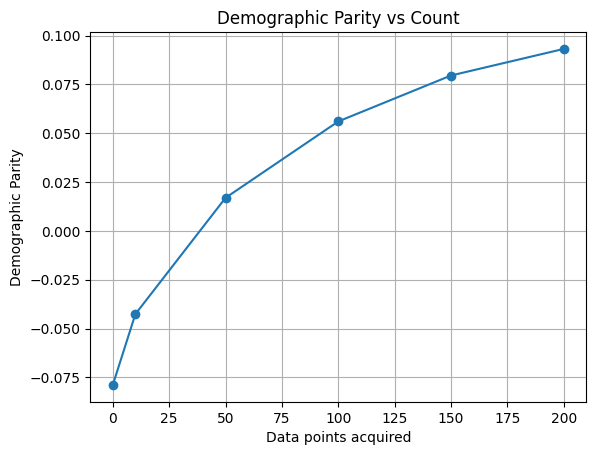

In [98]:
import matplotlib.pyplot as plt

counts = list(dp.keys())
dp_values = list(dp.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

In [99]:
#Define the counts for which to calculate dp
counts_to_check = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

dp[0] = -0.07884407

for index, res in sorted_result.items():
    # print(index)
    x_train_a = np.append(x_train_a, [x_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, x_test)
        print(f"Demographic Parity for first {current_count} data points: {dp}")
    
    if current_count == max(counts_to_check):
        break


Demographic Parity for first 5 data points: {0: -0.07884407, 5: -0.05863709654659033}
Demographic Parity for first 10 data points: {0: -0.07884407, 5: -0.05863709654659033, 10: -0.042600367777049564}
Demographic Parity for first 15 data points: {0: -0.07884407, 5: -0.05863709654659033, 10: -0.042600367777049564, 15: -0.029481126461178064}
Demographic Parity for first 20 data points: {0: -0.07884407, 5: -0.05863709654659033, 10: -0.042600367777049564, 15: -0.029481126461178064, 20: -0.020240381639450744}
Demographic Parity for first 25 data points: {0: -0.07884407, 5: -0.05863709654659033, 10: -0.042600367777049564, 15: -0.029481126461178064, 20: -0.020240381639450744, 25: -0.012711191549897194}
Demographic Parity for first 30 data points: {0: -0.07884407, 5: -0.05863709654659033, 10: -0.042600367777049564, 15: -0.029481126461178064, 20: -0.020240381639450744, 25: -0.012711191549897194, 30: -0.006060321349650621}
Demographic Parity for first 35 data points: {0: -0.07884407, 5: -0.058637

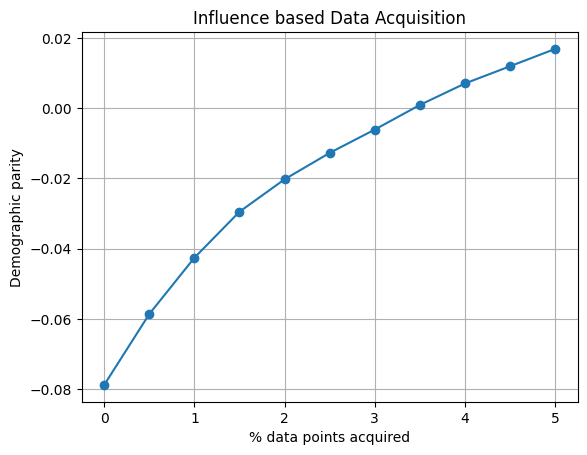

In [100]:
import matplotlib.pyplot as plta

counts = list(dp.keys())
counts_modified = [count / 10 for count in counts]
dp_values = list(dp.values())

# Plotting the dp values against the counts
plta.plot(counts_modified, dp_values, marker='o')
plta.title('Influence based Data Acquisition')
plta.xlabel('% data points acquired')
plta.ylabel('Demographic parity')
plta.grid(True)
plta.show()


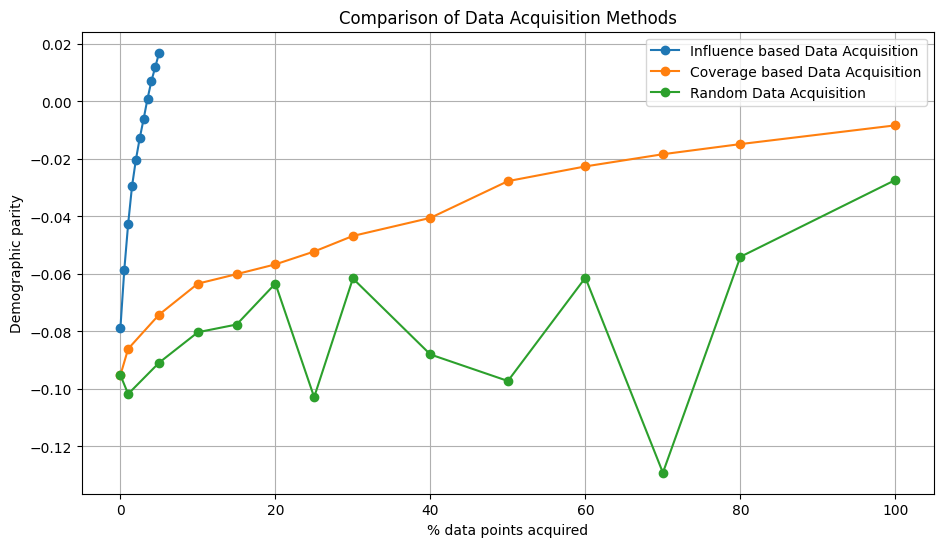

In [101]:

# Data for Influence based Data Acquisition
counts1 = list(dp.keys())
counts_modified1 = [count / 10 for count in counts1]
dp_values1 = list(dp.values())

# Data for Coverage based Data Acquisition
counts2 = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 100]
dp_values2 = [-0.0952, -0.08604, -0.07412, -0.06336, -0.06006, -0.05666, -0.0522, -0.04678, -0.0405, -0.02772, -0.0226, -0.01836, -0.01484, -0.00832]

# Data for Random Data Acquisition
counts3 = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 100]
dp_values3 = [-0.0952, -0.10174, -0.09084, -0.08026, -0.07758, -0.06334, -0.10284, -0.06158, -0.088, -0.09722, -0.0613, -0.12912, -0.05404, -0.02732]
plt.figure(figsize=(11, 6)) 

# Plotting the dp values against the counts
plt.plot(counts_modified1, dp_values1, marker='o', label='Influence based Data Acquisition')
plt.plot(counts2, dp_values2, marker='o', label='Coverage based Data Acquisition')
plt.plot(counts3, dp_values3, marker='o', label='Random Data Acquisition')

plt.title('Comparison of Data Acquisition Methods')
plt.xlabel('% data points acquired')
plt.ylabel('Demographic parity')
plt.grid(True)
plt.legend()  # Show legend with labels
plt.show()

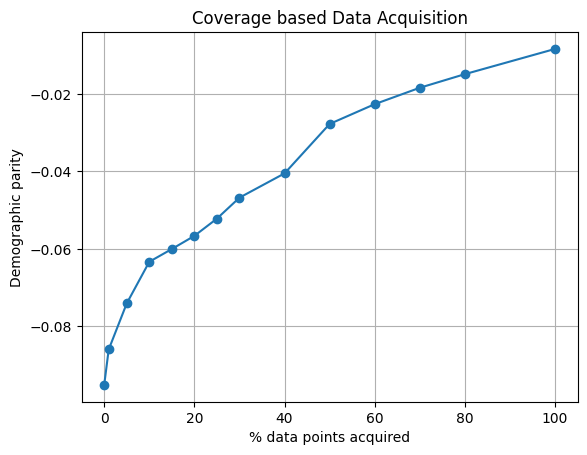

In [102]:
# Coverage based acquisition 

import matplotlib.pyplot as plt

counts = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 100]
dp_values = [-0.0952, -0.08604, -0.07412, -0.06336, -0.06006, -0.05666, -0.0522, -0.04678, -0.0405, -0.02772, -0.0226, -0.01836, -0.01484, -0.00832]

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Coverage based Data Acquisition')
plt.xlabel('% data points acquired')
plt.ylabel('Demographic parity')
plt.grid(True)
plt.show()

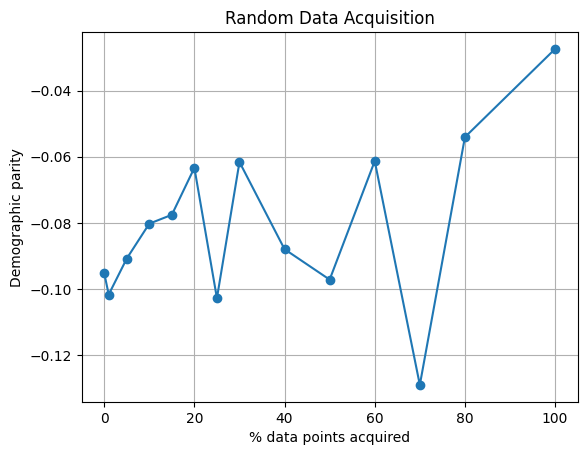

In [103]:
# Random based acquisition 

import matplotlib.pyplot as plt

counts = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 100]
dp_values = [-0.0952, -0.10174, -0.09084, -0.08026, -0.07758, -0.06334, -0.10284, -0.06158, -0.088, -0.09722, -0.0613, -0.12912, -0.05404, -0.02732]

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Random Data Acquisition')
plt.xlabel('% data points acquired')
plt.ylabel('Demographic parity')
plt.grid(True)
plt.show()

In [104]:
for count, dp_value in dp.items():
    print(f"Demographic Parity for first {count} data points: {dp_value}")

Demographic Parity for first 0 data points: -0.07884407
Demographic Parity for first 5 data points: -0.05863709654659033
Demographic Parity for first 10 data points: -0.042600367777049564
Demographic Parity for first 15 data points: -0.029481126461178064
Demographic Parity for first 20 data points: -0.020240381639450744
Demographic Parity for first 25 data points: -0.012711191549897194
Demographic Parity for first 30 data points: -0.006060321349650621
Demographic Parity for first 35 data points: 0.0009544180706143601
Demographic Parity for first 40 data points: 0.007077587395906471
Demographic Parity for first 45 data points: 0.011989723239094086
Demographic Parity for first 50 data points: 0.016932894103228957


In [105]:
clf = eval('LogisticRegression')(input_size=x_train.shape[-1])
if isinstance(clf, LogisticRegression):
    loss_func = logistic_loss_torch


In [106]:
del_F_del_theta = del_spd_del_theta(clf, x_test_orig, x_test_scalar, y_test)

In [107]:
hessian_all_points = get_hessian_all_points(clf, x_train, y_train, loss_func)


100%|██████████| 800/800 [00:05<00:00, 152.38it/s]


In [108]:
print(hessian_all_points.shape)

(800, 19, 19)


In [109]:
del_L_del_theta = get_del_L_del_theta(clf, x_train, y_train, loss_func)
print(type(del_L_del_theta))
print(del_L_del_theta.shape)

<class 'numpy.ndarray'>
(800, 19)


In [110]:
hinv_v, hinv = get_hinv_v(hessian_all_points, del_F_del_theta) 


In [111]:
print(hinv_v.shape)

(19,)


df/d_epsi = df/d_theta * d_theta/d_epsi

d_theta/d_epsi = (1/n)* -H_inv * dL/d_theta 

df/d_theta = del_F_del_theta

In [112]:
hinv_v, hinv = get_hinv_v(hessian_all_points, np.transpose(del_L_del_theta)) 
# it should be hessian* dL/d_theta 
# and then it should be multiplied by df/d_theta

In [113]:
#influence for each data point 
inf = np.matmul(np.transpose(hinv_v), del_F_del_theta)
# inf = inf * 0.00125
inf = inf/800
print(inf.shape)

(800,)


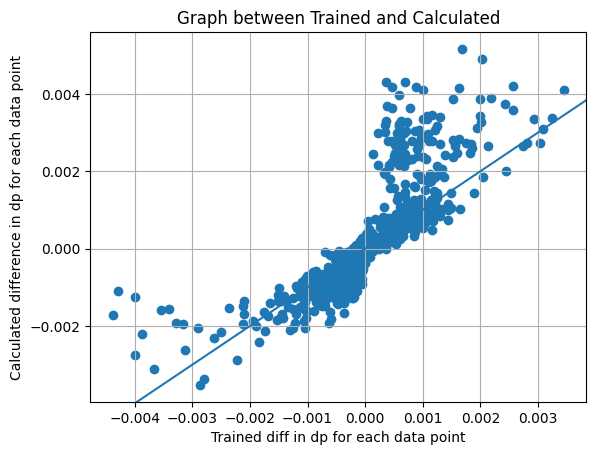

In [114]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
df = pd.DataFrame({'Trained': result_plot, 'Calculated': inf})
ax.scatter(df['Trained'], df['Calculated'], marker='o')
plt.title('Graph between Trained and Calculated')
plt.xlabel('Trained diff in dp for each data point')
plt.ylabel('Calculated difference in dp for each data point')
plt.grid(True)

ax.axline((0, 0), slope=1)
plt.show()


In [115]:
inf_list = {index: value for index, value in enumerate(inf)}

In [116]:
# INFLUENCE BASED SORTED DP FOR EACH DATA POINT
sorted_result_inf = {k: v for k, v in sorted(inf_list.items(), key=lambda item: item[1])}

In [117]:
for key in sorted_result_inf:
    print(key)

652
238
405
161
770
597
732
89
553
378
247
223
757
620
8
398
386
265
393
450
739
661
626
314
220
612
559
28
292
198
319
58
12
379
771
548
359
263
18
52
423
98
289
761
84
749
429
397
714
542
309
231
733
552
108
213
272
239
368
695
672
465
617
104
589
385
766
46
424
287
487
596
103
762
336
224
478
639
515
240
350
555
264
697
3
221
756
326
456
699
438
776
295
489
602
101
31
753
80
603
341
422
23
473
260
690
122
159
123
741
112
540
366
606
120
564
269
775
190
144
493
54
132
759
373
343
720
651
73
270
92
418
259
53
32
789
351
641
486
321
235
677
176
346
138
508
192
622
158
45
334
780
495
522
649
200
549
332
284
250
502
736
90
367
574
683
551
758
109
643
635
767
705
331
128
96
576
691
744
640
504
66
335
10
348
520
611
527
431
546
404
67
388
723
534
491
298
55
95
60
185
215
407
544
345
253
7
525
308
779
394
201
459
565
13
361
75
156
471
594
130
482
722
197
628
387
79
107
91
358
21
83
71
715
455
501
244
413
448
189
658
172
507
512
513
149
121
629
365
536
412
323
678
681
383
532
111
262
538
203

In [118]:
file_path = "german_inf_sorted.txt"

# Open the file in write mode
with open(file_path, "w") as file:
    # Iterate over the list and write each element to the file
    for item in sorted_result_inf:
        file.write(str(item) + "\n")

In [119]:
#Define the counts for which to calculate dp
counts_to_check = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

current_count = 0
dp_inf = {}

dp_inf[0] = -0.07884407

for index, res in sorted_result_inf.items():
    # print(index)
    x_train_a = np.append(x_train_a, [x_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count in counts_to_check:
        dp_inf[current_count] = demographic_parity(x_train_a, y_train_a, x_test)
        print(f"Demographic Parity for first {current_count} data points: {dp_inf}")
    
    if current_count == max(counts_to_check):
        break

Demographic Parity for first 5 data points: {0: -0.07884407, 5: -0.06372094461694355}
Demographic Parity for first 10 data points: {0: -0.07884407, 5: -0.06372094461694355, 10: -0.05062527023255825}
Demographic Parity for first 15 data points: {0: -0.07884407, 5: -0.06372094461694355, 10: -0.05062527023255825, 15: -0.04315075026825066}
Demographic Parity for first 20 data points: {0: -0.07884407, 5: -0.06372094461694355, 10: -0.05062527023255825, 15: -0.04315075026825066, 20: -0.03526598429307348}
Demographic Parity for first 25 data points: {0: -0.07884407, 5: -0.06372094461694355, 10: -0.05062527023255825, 15: -0.04315075026825066, 20: -0.03526598429307348, 25: -0.028481886815279744}
Demographic Parity for first 30 data points: {0: -0.07884407, 5: -0.06372094461694355, 10: -0.05062527023255825, 15: -0.04315075026825066, 20: -0.03526598429307348, 25: -0.028481886815279744, 30: -0.019192317780107326}
Demographic Parity for first 35 data points: {0: -0.07884407, 5: -0.06372094461694355,

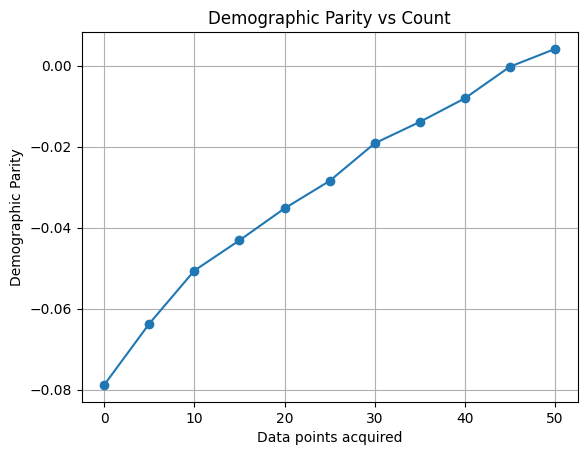

In [120]:
import matplotlib.pyplot as plt

counts = list(dp_inf.keys())
dp_values = list(dp_inf.values())

# Plotting the dp values against the counts
plt.plot(counts, dp_values, marker='o')
plt.title('Demographic Parity vs Count')
plt.xlabel('Data points acquired')
plt.ylabel('Demographic Parity')
plt.grid(True)
plt.show()

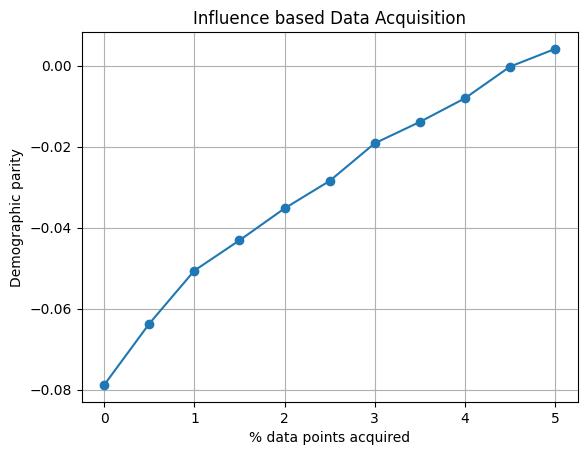

In [121]:
import matplotlib.pyplot as plta

counts = list(dp_inf.keys())
counts_modified = [count / 10 for count in counts]
dp_values = list(dp_inf.values())

# Plotting the dp values against the counts
plta.plot(counts_modified, dp_values, marker='o')
plta.title('Influence based Data Acquisition')
plta.xlabel('% data points acquired')
plta.ylabel('Demographic parity')
plta.grid(True)
plta.show()

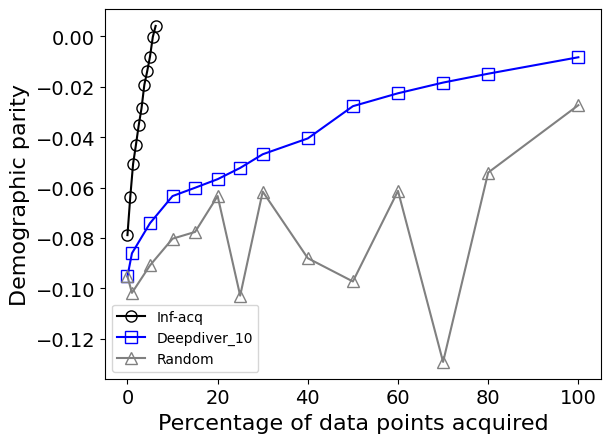

In [154]:
# Data for Influence based Data Acquisition calculating influence 
counts1 = list(dp_inf.keys())
counts_modified1 = [count / 8 for count in counts1]
dp_values1 = list(dp_inf.values())

# Data for Coverage based Data Acquisition
counts2 = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 100]
dp_values2 = [-0.0952, -0.08604, -0.07412, -0.06336, -0.06006, -0.05666, -0.0522, -0.04678, -0.0405, -0.02772, -0.0226, -0.01836, -0.01484, -0.00832]

# Data for Random Data Acquisition
counts3 = [0, 1, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 100]
dp_values3 = [-0.0952, -0.10174, -0.09084, -0.08026, -0.07758, -0.06334, -0.10284, -0.06158, -0.088, -0.09722, -0.0613, -0.12912, -0.05404, -0.02732]

# Plotting the dp values against the counts
plt.plot(counts_modified1, dp_values1, marker='o', markerfacecolor='none', markersize=8, color='black',label='Inf-acq')
plt.plot(counts2, dp_values2, marker='s',  markerfacecolor='none', markersize=8,color='blue', label='Deepdiver_10')
plt.plot(counts3, dp_values3, marker='^',  markerfacecolor='none', markersize=8, color='gray',label='Random')

# plt.title('Comparison of Data Acquisition Methods')
plt.xlabel('Percentage of data points acquired', fontsize=16)
plt.ylabel('Demographic parity', fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=13)
# plt.grid(True)
plt.legend()  # Show legend with labels
plt.show()

In [123]:
# Influence based data acquisition for a particular number of data points

# count_to_check = 3 #for threshold 10
# count_to_check = 13 #for threshold = 50
# count_to_check = 38
count_to_check = 35

x_train_a = np.copy(x_train)
y_train_a = np.copy(y_train)

current_count = 0
dp = {}

dp[0] = -0.07884407

for index, res in sorted_result.items():
    x_train_a = np.append(x_train_a, [x_train[index]], axis=0)
    y_train_a = np.append(y_train_a, [y_train[index]])
    current_count += 1
    if current_count == count_to_check:
        dp[current_count] = demographic_parity(x_train_a, y_train_a, x_test)
        print(f"Demographic Parity for {count_to_check} data points: {dp}")
        break 
print(len(x_train_a)) 

Demographic Parity for 35 data points: {0: -0.07884407, 35: 0.0009544180706143601}
835


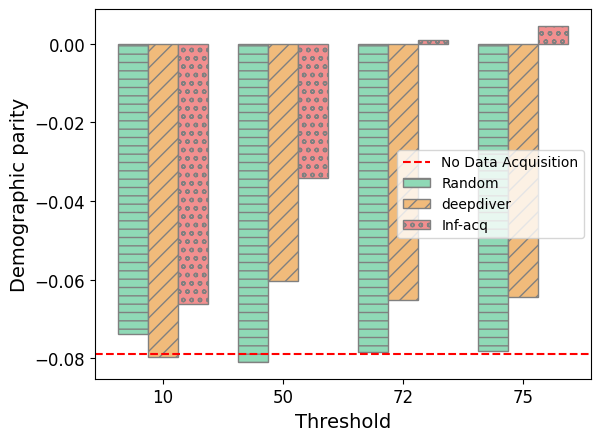

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Data for each acquisition method
random_data = [[10, -0.07390597], [50, -0.08090806],[72, -0.07835707], [75,  -0.0781675]]  # for threshold 10, 3 data points are acquired, for threshold = 50, 13 data points are aacquired 
coverage_based_data = [[10, -0.07972045], [50, -0.06040341], [72, -0.0651996], [75, -0.06451435]]
influence_based_data = [[10, -0.0662626], [50, -0.034276], [72, 0.0009544], [75, 0.0045129142]]

# Extracting x and y values for each method
threshold_random, dp_random = zip(*random_data)
threshold_coverage, dp_coverage = zip(*coverage_based_data)
threshold_influence, dp_influence = zip(*influence_based_data)

# Set width of bar
bar_width = 0.25

# Set position of bar on X axis
r1 = np.arange(len(threshold_random))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the bars
plt.bar(r1, dp_random, color='#8fd9b6', width=bar_width, edgecolor='grey', label='Random', hatch='--')
plt.bar(r2, dp_coverage, color='#f1bb7b', width=bar_width, edgecolor='grey', label='Deepdiver_10', hatch='//')
plt.bar(r3, dp_influence, color='#f28f8f', width=bar_width, edgecolor='grey', label='Inf-acq', hatch='oo')

plt.axhline(y=-0.07884407313540576, color='red', linestyle='--', label='No Data Acquisition')

# Adding labels and title
plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Demographic parity', fontsize=14)
plt.xticks([r + bar_width for r in range(len(threshold_random))], threshold_random, fontsize =12)
plt.yticks(fontsize=12)
plt.legend()

# Show plot
plt.show()


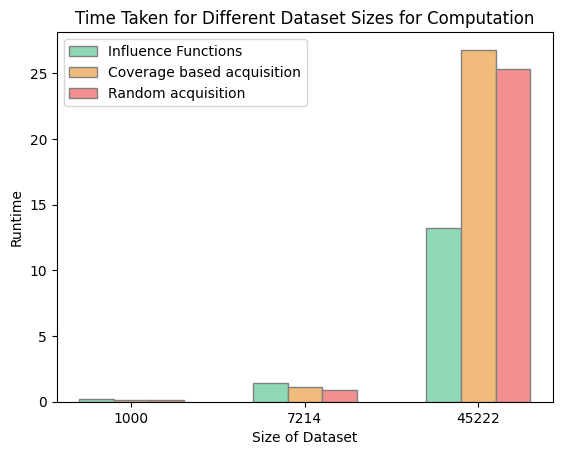

In [125]:
#Metrics table

import numpy as np
import matplotlib.pyplot as plt

# Dataset sizes
dataset_sizes = [1000, 7214, 45222]

# Time measurements for each dataset size and method
# Retraining = [21.5, 567.8, 6915]
IF = [0.2, 1.4, 13.2]
CBA = [0.15, 1.1, 26.8]
Random = [0.11,0.91,25.3]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(dataset_sizes))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the bars
plt.bar(r1, IF, color='#8fd9b6', width=bar_width, edgecolor='grey', label='Influence Functions')
plt.bar(r2, CBA, color='#f1bb7b', width=bar_width, edgecolor='grey', label='Coverage based acquisition')
plt.bar(r3, Random, color='#f28f8f', width=bar_width, edgecolor='grey', label='Random acquisition')

# Adding labels and title
plt.xlabel('Size of Dataset')
plt.ylabel('Runtime')
plt.title('Time Taken for Different Dataset Sizes for Computation')
plt.xticks([r + bar_width for r in range(len(dataset_sizes))], dataset_sizes)
plt.legend()

# Show plot
plt.show()


In [126]:
#IF static time to calculate hessians 
# Adult = 132.2sec
# german = 3.7sec
# Compas = 17.7sec


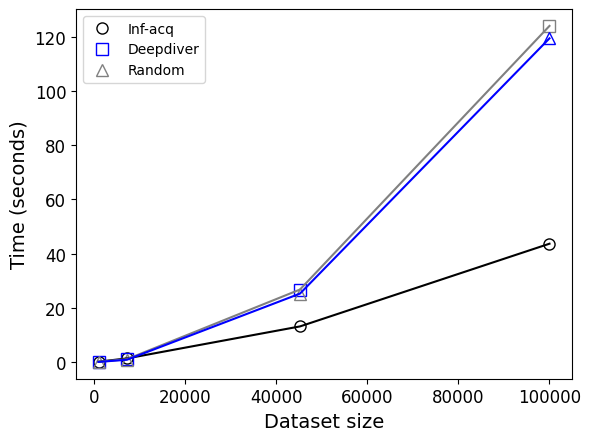

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

dataset_sizes = np.array([1000, 7214, 45222])
influence_times = np.array([0.2, 1.4, 13.2])
deepdiver_times = np.array([0.15, 1.1, 26.8])
random_times = np.array([0.11, 0.91, 25.3])


new_sizes = np.array([100000])


all_sizes = np.concatenate((dataset_sizes, new_sizes))

def extrapolate_times_poly(sizes, times, new_sizes, degree=2):
   
    poly = PolynomialFeatures(degree)
    sizes_poly = poly.fit_transform(sizes.reshape(-1, 1))
    new_sizes_poly = poly.transform(new_sizes.reshape(-1, 1))
    
  
    model = LinearRegression()
    model.fit(sizes_poly, times)
    
   
    extrapolated_times = model.predict(new_sizes_poly)
    return extrapolated_times


extrapolated_influence_times = extrapolate_times_poly(dataset_sizes, influence_times, new_sizes)
extrapolated_deepdiver_times = extrapolate_times_poly(dataset_sizes, deepdiver_times, new_sizes)
extrapolated_random_times = extrapolate_times_poly(dataset_sizes, random_times, new_sizes)


all_influence_times = np.concatenate((influence_times, extrapolated_influence_times))
all_deepdiver_times = np.concatenate((deepdiver_times, extrapolated_deepdiver_times))
all_random_times = np.concatenate((random_times, extrapolated_random_times))

plt.plot(dataset_sizes, influence_times, 'o', markerfacecolor='none', markersize=8, label='Inf-acq', color='black')
plt.plot(dataset_sizes, deepdiver_times, 's', markerfacecolor='none', markersize=8,label='Deepdiver', color='blue')
plt.plot(dataset_sizes, random_times, '^', markerfacecolor='none', markersize=8,  label='Random', color='gray') 

plt.plot(all_sizes, all_influence_times, '-',  color='black')
plt.plot(all_sizes, all_deepdiver_times, '-', color='gray')
plt.plot(all_sizes, all_random_times, '-', color='blue') 


plt.plot(new_sizes, extrapolated_influence_times, 'o', markerfacecolor='none', markersize=8, color='black')
plt.plot(new_sizes, extrapolated_deepdiver_times, 's',markerfacecolor='none', markersize=8,  color='gray')
plt.plot(new_sizes, extrapolated_random_times, '^', markerfacecolor='none', markersize=8,color='blue')  

plt.xlabel('Dataset size', fontsize = 14)
plt.ylabel('Time (seconds)', fontsize = 14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend()

plt.show()




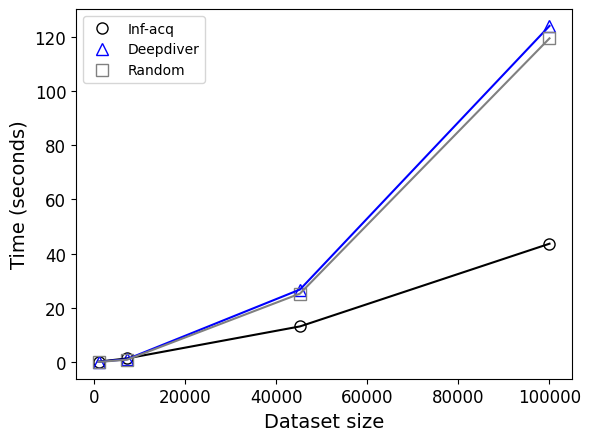

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

dataset_sizes = np.array([1000, 7214, 45222])
influence_times = np.array([0.2, 1.4, 13.2])
deepdiver_times = np.array([0.15, 1.1, 26.8])
random_times = np.array([0.11, 0.91, 25.3])

new_sizes = np.array([100000])

all_sizes = np.concatenate((dataset_sizes, new_sizes))

def extrapolate_times_poly(sizes, times, new_sizes, degree=2):
    poly = PolynomialFeatures(degree)
    sizes_poly = poly.fit_transform(sizes.reshape(-1, 1))
    new_sizes_poly = poly.transform(new_sizes.reshape(-1, 1))
    
    model = LinearRegression()
    model.fit(sizes_poly, times)
    
    extrapolated_times = model.predict(new_sizes_poly)
    return extrapolated_times

extrapolated_influence_times = extrapolate_times_poly(dataset_sizes, influence_times, new_sizes)
extrapolated_deepdiver_times = extrapolate_times_poly(dataset_sizes, deepdiver_times, new_sizes)
extrapolated_random_times = extrapolate_times_poly(dataset_sizes, random_times, new_sizes)

all_influence_times = np.concatenate((influence_times, extrapolated_influence_times))
all_deepdiver_times = np.concatenate((deepdiver_times, extrapolated_deepdiver_times))
all_random_times = np.concatenate((random_times, extrapolated_random_times))

plt.plot(dataset_sizes, influence_times, 'o', markerfacecolor='none', markersize=8, label='Inf-acq', color='black')
plt.plot(dataset_sizes, deepdiver_times, '^', markerfacecolor='none', markersize=8,label='Deepdiver', color='blue')
plt.plot(dataset_sizes, random_times, 's', markerfacecolor='none', markersize=8,  label='Random', color='gray') 

plt.plot(all_sizes, all_influence_times, '-',  color='black')
plt.plot(all_sizes, all_deepdiver_times, '-', color='blue')
plt.plot(all_sizes, all_random_times, '-', color='gray') 

plt.plot(new_sizes, extrapolated_influence_times, 'o', markerfacecolor='none', markersize=8, color='black')
plt.plot(new_sizes, extrapolated_deepdiver_times, '^',markerfacecolor='none', markersize=8,  color='blue')
plt.plot(new_sizes, extrapolated_random_times, 's', markerfacecolor='none', markersize=8,color='gray')  

plt.xlabel('Dataset size', fontsize = 14)
plt.ylabel('Time (seconds)', fontsize = 14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend()

plt.show()
